## Sandcamera ML model

This notebook builds, trains, and quantized the SandCamera ML model.There are XX general steps

- First - build the network, which is inspired by SediNet (Buscombe 2019)
- Second - train the model
- Third - use Quantization Aware Training to reduce the weights, biases in the model to 8 bits, except for the final Dense classification layers, which are kept at 32 floating point. (This allows for better prediction for regression problems.)
- Fourth - convert the model to TensorFlow Lite format and test the output
- Fifth - link to tools to compile the model for Google Coral EdgeTPU

In [1]:
# import the general stuff
import os
from os import getcwd
import pathlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd 
import numpy as np

#If multiple GPU, set which GPU to use
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

#import the tf stuff
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
import tensorflow_model_optimization as tfmot
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

TF version: 2.8.0


In [2]:
#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

No GPU


In [4]:
#build data generators for training and validaton

#split is 70/20/10 for 300 images, so XX 210 image, 60 images, 30 images.. 
#the 30 have been removed for testing already, so its 22.23% of teh remaining images as validation
split = 0.2

df = pd.read_csv('../data/SedMLdataAug22.csv')


columns=["D2mm", "D5mm", "D10mm", "D16mm",
"D25mm","D50mm", "D75mm", "D84mm", "D90mm",
"D95mm", "D98mm"]


# Define dirs and files
data_dir = '../data/CropPics'

# Add our data-augmentation parameters to ImageDataGenerator and split data
datagen = ImageDataGenerator(rescale = 1./255.,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   #rotation_range = 90,
                                   #width_shift_range = 0.5,
                                   #height_shift_range = 0.5,
                                   fill_mode = 'reflect',
                                 validation_split = split)


#set batch Size
batch_size = 8

#set color
# c_ch = 1
# c_mode = 'grayscale'
c_ch = 3
c_mode = 'rgb'

#set Image size (RGB so imshape is 3)
pix_dim = 224
imsize = (pix_dim, pix_dim) 
imshape = (pix_dim, pix_dim, c_ch)

# Flow training images in batches 
train_generator = datagen.flow_from_dataframe(dataframe = df,
                                                    directory = data_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'raw',
                                                    x_col = 'CropName',
                                                    y_col = columns,
                                                    target_size = imsize,
                                                    color_mode = c_mode,
                                                    subset ='training')

# Flow validation images in batches 
validation_generator =  datagen.flow_from_dataframe(dataframe=df,
                                                          directory = data_dir,
                                                          batch_size = batch_size,
                                                          class_mode = 'raw',
                                                          x_col = 'CropName',
                                                          y_col = columns,
                                                          target_size = imsize,
                                                          color_mode = c_mode,
                                                       subset ='validation')


Found 397 validated image filenames.
Found 99 validated image filenames.


Stats : [0.0768     0.09565    0.10967778 0.12131154 0.136225   0.17810833
 0.24042727 0.2936     0.3787     0.58475    0.8973    ]


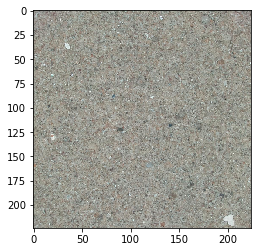

Stats : [0.237      0.31045    0.4505     1.0318     1.45221429 2.32265385
 3.07478571 3.5016625  3.79336842 4.26283125 4.67696667]


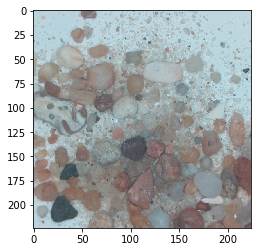

Stats : [0.16383333 0.18235714 0.20028077 0.21580588 0.2356381  0.28942727
 0.36986    0.425265   0.50569    0.6579     0.8252    ]


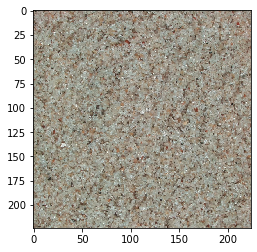

Stats : [0.14113333 0.1612     0.18559375 0.21340625 0.2662625  0.5119
 1.10125    1.907475   2.60674545 3.36575    3.58591   ]


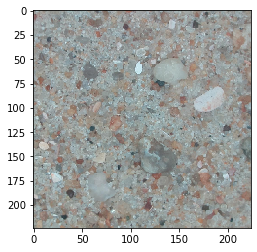

Stats : [0.15781667 0.175925   0.19323846 0.20859118 0.22781905 0.27938333
 0.34751389 0.38564643 0.42448    0.48182    0.60695   ]


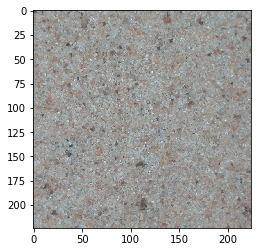

Stats : [0.18775    0.21505714 0.23995    0.26042813 0.28565238 0.34486429
 0.4147     0.4539     0.49543    0.56335    0.672375  ]


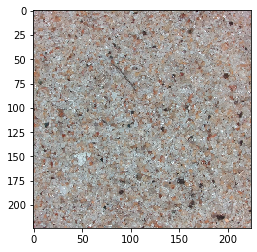

Stats : [0.0859     0.10311    0.11845    0.13321364 0.1537125  0.22
 0.52618333 1.14305    2.59345    4.71676228 4.76331491]


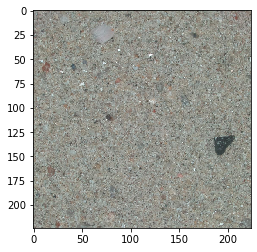

Stats : [0.1509     0.16706429 0.18220769 0.19509211 0.210582   0.2483
 0.2961     0.3229625  0.34933333 0.38615714 0.43405   ]


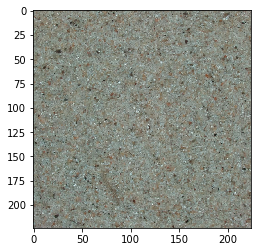

In [5]:
#show augs

how_many = 1
how_many = batch_size

x = train_generator.next()

for i in range(0,how_many):
    image = x[0][i]   # batch[0] images, batch[1] labels... 
    plt.imshow(image.squeeze())   #squeeze for grayscale images
    print('Stats :', x[1][i])
    plt.show()

In [6]:
#load or build model
##########

#from scratch:
#base model, no top layer, w/ imagenet weights
base_model = tf.keras.applications.MobileNetV2(input_shape = imshape, 
                                             include_top = False, 
                                             weights = 'imagenet')

# to freeze the batch Norm layers
base_model.training = False

#base model not trainable
base_model.trainable = False

# add a new classifcation layer
final_layer = base_model.get_layer('out_relu')
#print('shape of last layer is ', final_layer.output_shape)
final_base_output = final_layer.output

# add avg pool
x = layers.GlobalAveragePooling2D()(final_base_output)
#add a dense
x = layers.Dense(512, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(1e-4))(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final linear layer for classification
x = layers.Dense(len(columns), activation='relu')(x) 


model = Model(base_model.input, x) 
#############
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [7]:
# define other metrics
MAE = tf.keras.metrics.MeanAbsoluteError(name='mae')
MSE = tf.keras.metrics.MeanSquaredError(name='mse')


In [9]:
#compile
#by plotting a loss curve, min occurs w/ Adam() at lr = 1e-2. but i am gettign better results by using default lr.

model.compile(loss = tf.keras.losses.MeanAbsolutePercentageError(), 
              optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4), 
              metrics = [MAE, MSE]
             )

In [10]:
# define a callback

early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                             patience = 40, 
                                             restore_best_weights = True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor = 0.2,
                                                 verbose = 1,
                                                 patience = 5)

In [11]:
#train the model
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs= 200,
                    workers = 24,
                    callbacks =[early_stop, reduce_lr])



Epoch 1/200
50/50 [==============================] - 7s 107ms/step - loss: 105.1557 - mae: 0.5674 - mse: 0.7670 - val_loss: 89.3655 - val_mae: 0.6300 - val_mse: 0.9445 - lr: 1.0000e-04
Epoch 2/200
50/50 [==============================] - 5s 95ms/step - loss: 90.5043 - mae: 0.4576 - mse: 0.4523 - val_loss: 82.0813 - val_mae: 0.4893 - val_mse: 0.5293 - lr: 1.0000e-04
Epoch 3/200
50/50 [==============================] - 5s 89ms/step - loss: 88.4236 - mae: 0.4332 - mse: 0.3918 - val_loss: 74.8385 - val_mae: 0.4122 - val_mse: 0.3953 - lr: 1.0000e-04
Epoch 4/200
50/50 [==============================] - 4s 86ms/step - loss: 86.3626 - mae: 0.4216 - mse: 0.3854 - val_loss: 73.8388 - val_mae: 0.4127 - val_mse: 0.4151 - lr: 1.0000e-04
Epoch 5/200
50/50 [==============================] - 4s 88ms/step - loss: 82.6493 - mae: 0.3878 - mse: 0.3155 - val_loss: 71.6817 - val_mae: 0.3973 - val_mse: 0.4025 - lr: 1.0000e-04
Epoch 6/200
50/50 [==============================] - 5s 89ms/step - loss: 79.1709 -

Epoch 45/200
50/50 [==============================] - 4s 88ms/step - loss: 24.9307 - mae: 0.1989 - mse: 0.2160 - val_loss: 21.0219 - val_mae: 0.2721 - val_mse: 0.4228 - lr: 2.0000e-05
Epoch 46/200
50/50 [==============================] - 5s 87ms/step - loss: 24.5170 - mae: 0.1920 - mse: 0.2058 - val_loss: 20.5195 - val_mae: 0.2688 - val_mse: 0.4299 - lr: 2.0000e-05
Epoch 47/200
50/50 [==============================] - 4s 88ms/step - loss: 25.2370 - mae: 0.2010 - mse: 0.2191 - val_loss: 20.3528 - val_mae: 0.2623 - val_mse: 0.4187 - lr: 2.0000e-05
Epoch 48/200
50/50 [==============================] - 4s 87ms/step - loss: 25.2554 - mae: 0.1995 - mse: 0.2183 - val_loss: 20.8276 - val_mae: 0.2644 - val_mse: 0.4026 - lr: 2.0000e-05
Epoch 49/200
50/50 [==============================] - 4s 88ms/step - loss: 23.7444 - mae: 0.1926 - mse: 0.2168 - val_loss: 20.1438 - val_mae: 0.2640 - val_mse: 0.4121 - lr: 2.0000e-05
Epoch 50/200
50/50 [==============================] - 5s 89ms/step - loss: 23.78

Epoch 86/200
50/50 [==============================] - 5s 92ms/step - loss: 22.1560 - mae: 0.1818 - mse: 0.1993 - val_loss: 19.8122 - val_mae: 0.2665 - val_mse: 0.4265 - lr: 3.2000e-08
Epoch 87/200
50/50 [==============================] - 5s 89ms/step - loss: 22.5746 - mae: 0.1846 - mse: 0.1964 - val_loss: 18.9851 - val_mae: 0.2597 - val_mse: 0.4145 - lr: 3.2000e-08
Epoch 88/200
50/50 [==============================] - 5s 90ms/step - loss: 22.4455 - mae: 0.1842 - mse: 0.2025 - val_loss: 20.1723 - val_mae: 0.2682 - val_mse: 0.4226 - lr: 3.2000e-08
Epoch 89/200
50/50 [==============================] - 5s 91ms/step - loss: 22.5239 - mae: 0.1860 - mse: 0.2009 - val_loss: 19.8993 - val_mae: 0.2627 - val_mse: 0.4048 - lr: 3.2000e-08
Epoch 90/200
50/50 [==============================] - 5s 89ms/step - loss: 23.2530 - mae: 0.1928 - mse: 0.2122 - val_loss: 19.2661 - val_mae: 0.2573 - val_mse: 0.4057 - lr: 3.2000e-08
Epoch 91/200
50/50 [==============================] - 5s 89ms/step - loss: 22.73

Epoch 125/200
50/50 [==============================] - 5s 90ms/step - loss: 23.0786 - mae: 0.1896 - mse: 0.2079 - val_loss: 19.6335 - val_mae: 0.2619 - val_mse: 0.4111 - lr: 2.0480e-12
Epoch 126/200
50/50 [==============================] - 5s 90ms/step - loss: 23.0545 - mae: 0.1896 - mse: 0.2069 - val_loss: 19.4405 - val_mae: 0.2605 - val_mse: 0.4094 - lr: 2.0480e-12
Epoch 127/200
50/50 [==============================] - ETA: 0s - loss: 23.3053 - mae: 0.1844 - mse: 0.1981
Epoch 127: ReduceLROnPlateau reducing learning rate to 4.0959995811773456e-13.
50/50 [==============================] - 5s 90ms/step - loss: 23.3053 - mae: 0.1844 - mse: 0.1981 - val_loss: 19.7610 - val_mae: 0.2600 - val_mse: 0.4140 - lr: 2.0480e-12
Epoch 128/200
50/50 [==============================] - 5s 90ms/step - loss: 22.9040 - mae: 0.1846 - mse: 0.1972 - val_loss: 19.5765 - val_mae: 0.2588 - val_mse: 0.4100 - lr: 4.0960e-13
Epoch 129/200
50/50 [==============================] - 5s 91ms/step - loss: 22.4451 - ma

Epoch 163/200
50/50 [==============================] - 5s 92ms/step - loss: 23.2437 - mae: 0.1862 - mse: 0.1940 - val_loss: 19.2598 - val_mae: 0.2638 - val_mse: 0.4271 - lr: 2.6214e-17
Epoch 164/200
50/50 [==============================] - ETA: 0s - loss: 23.2208 - mae: 0.1896 - mse: 0.2053
Epoch 164: ReduceLROnPlateau reducing learning rate to 5.2428798336199434e-18.
50/50 [==============================] - 5s 90ms/step - loss: 23.2208 - mae: 0.1896 - mse: 0.2053 - val_loss: 19.2399 - val_mae: 0.2565 - val_mse: 0.4014 - lr: 2.6214e-17
Epoch 165/200
50/50 [==============================] - 5s 92ms/step - loss: 22.7181 - mae: 0.1886 - mse: 0.2130 - val_loss: 19.4025 - val_mae: 0.2643 - val_mse: 0.4270 - lr: 5.2429e-18
Epoch 166/200
50/50 [==============================] - 5s 90ms/step - loss: 23.3841 - mae: 0.1895 - mse: 0.2025 - val_loss: 19.6550 - val_mae: 0.2604 - val_mse: 0.4130 - lr: 5.2429e-18
Epoch 167/200
50/50 [==============================] - 5s 93ms/step - loss: 22.8185 - ma

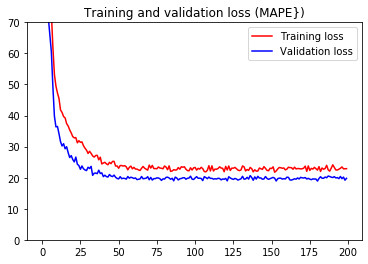

<Figure size 432x288 with 0 Axes>

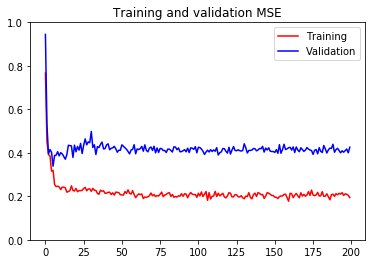

<Figure size 432x288 with 0 Axes>

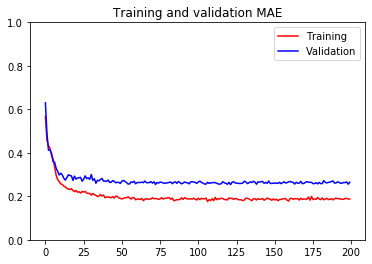

<Figure size 432x288 with 0 Axes>

In [12]:
#look at the metrics from training
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.ylim(0,70)

plt.title('Training and validation loss (MAPE})')
plt.legend(loc=0)
plt.figure()
plt.show()

mse = history.history['mse']
val_mse = history.history['val_mse']

plt.plot(epochs, mse, 'r', label='Training')
plt.plot(epochs, val_mse, 'b', label='Validation')
plt.ylim(0,1)

plt.title('Training and validation MSE')
plt.legend(loc=0)
plt.figure()
plt.show()

mae = history.history['mae']
val_mae = history.history['val_mae']

plt.plot(epochs, mae, 'r', label='Training')
plt.plot(epochs, val_mae, 'b', label='Validation')
plt.ylim(0,1)

plt.title('Training and validation MAE')
plt.legend(loc=0)
plt.figure()
plt.show()



In [13]:
#evaluate full model on val* set:
model.evaluate(validation_generator)

13/13 [==============================] - 1s 73ms/step - loss: 19.4424 - mae: 0.2571 - mse: 0.4028


[19.442401885986328, 0.25705161690711975, 0.40277916193008423]

In [ ]:
# #Full model finetune
# base_model.trainable = True

# #compile
# model.compile(loss = tf.keras.losses.MeanAbsolutePercentageError(), 
#               optimizer=tf.keras.optimizers.RMSprop(lr = 1e-9), 
#               metrics = [MAE, MSE]
#              )

# #train the model
# history = model.fit(train_generator,
#                     validation_data = validation_generator,
#                     epochs= 200,
#                     workers = 24,
#                     callbacks =[early_stop, reduce_lr])

# #look at the metrics from training
# %matplotlib inline

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs = range(len(loss))

# plt.plot(epochs, loss, 'r', label='Training loss')
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.ylim(0,70)

# plt.title('Training and validation loss (MAPE})')
# plt.legend(loc=0)
# plt.figure()
# plt.show()

# mse = history.history['mse']
# val_mse = history.history['val_mse']

# plt.plot(epochs, mse, 'r', label='Training')
# plt.plot(epochs, val_mse, 'b', label='Validation')
# plt.ylim(0,1)

# plt.title('Training and validation MSE')
# plt.legend(loc=0)
# plt.figure()
# plt.show()

# mae = history.history['mae']
# val_mae = history.history['val_mae']

# plt.plot(epochs, mae, 'r', label='Training')
# plt.plot(epochs, val_mae, 'b', label='Validation')
# plt.ylim(0,1)

# plt.title('Training and validation MAE')
# plt.legend(loc=0)
# plt.figure()
# plt.show()

# #evaluate full model on val* set:
# model.evaluate(validation_generator)

Stats : [0.16485    0.19059    0.213505   0.23208125 0.25381364 0.30319138
 0.36035    0.39206471 0.42605    0.48003    0.56865   ]
Predicted Stats: [[0.16050898 0.16195203 0.19319388 0.21477553 0.23307705 0.30027366
  0.37233722 0.43626913 0.458377   0.558831   0.61968356]]


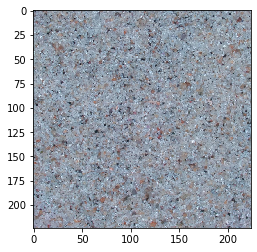

In [14]:
# use the validation generator as a sanity check

x = validation_generator.next()

how_many = 1
#how_many = batch_size

for i in range(0,how_many):
    image = x[0][i]   # batch[0] images, batch[1] labels... 
    #make a prediction
    img = np.expand_dims(image,axis=0)
    predStats = model.predict(img)
    
    plt.imshow(image.squeeze())   #squeeze for grayscale images  
    print('Stats :',x[1][i])
    print('Predicted Stats:', predStats)
    plt.show()

In [15]:
#save the model
filepath = './models/SNmodel_MN2_aug22'
model.save(filepath)


INFO:tensorflow:Assets written to: ./models/SNmodel_MN2_aug22/assets


In [16]:
#reload model, if needed
# model = tf.keras.models.load_model('./models/SNmodel_MN2_aug22')
# model.summary()

In [17]:
#quantize all layers but dense iwth not isinstance

# Helper function  to annotate all non dense layters
def apply_quantization_to_not_dense(layer):
  if not isinstance(layer, (tf.keras.layers.Dense,tf.keras.layers.Dropout)):
    return tfmot.quantization.keras.quantize_annotate_layer(layer)
  return layer

# Use `tf.keras.models.clone_model` to apply `apply_quantization_to_dense` 
# to the layers of the model.
annotated_model = tf.keras.models.clone_model(
    model,
    clone_function = apply_quantization_to_not_dense,
)


# Now that non- Dense layers are annotated,
# `quantize_apply` actually makes the model quantization aware.
quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)
quant_aware_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 quantize_layer (QuantizeLayer)  (None, 224, 224, 3)  3          ['input_1[0][0]']                
                                                                                                  
 quant_Conv1 (QuantizeWrapperV2  (None, 112, 112, 32  929        ['quantize_layer[1][0]']         
 )                              )                                                                 
                                                                                              

 quant_block_2_add (QuantizeWra  (None, 56, 56, 24)  3           ['quant_block_1_project_BN[0][0]'
 pperV2)                                                         , 'quant_block_2_project_BN[0][0]
                                                                 ']                               
                                                                                                  
 quant_block_3_expand (Quantize  (None, 56, 56, 144)  3745       ['quant_block_2_add[0][0]']      
 WrapperV2)                                                                                       
                                                                                                  
 quant_block_3_expand_BN (Quant  (None, 56, 56, 144)  577        ['quant_block_3_expand[0][0]']   
 izeWrapperV2)                                                                                    
                                                                                                  
 quant_blo

 quant_block_5_add (QuantizeWra  (None, 28, 28, 32)  3           ['quant_block_4_add[0][0]',      
 pperV2)                                                          'quant_block_5_project_BN[0][0]'
                                                                 ]                                
                                                                                                  
 quant_block_6_expand (Quantize  (None, 28, 28, 192)  6529       ['quant_block_5_add[0][0]']      
 WrapperV2)                                                                                       
                                                                                                  
 quant_block_6_expand_BN (Quant  (None, 28, 28, 192)  769        ['quant_block_6_expand[0][0]']   
 izeWrapperV2)                                                                                    
                                                                                                  
 quant_blo

 quant_block_8_add (QuantizeWra  (None, 14, 14, 64)  3           ['quant_block_7_add[0][0]',      
 pperV2)                                                          'quant_block_8_project_BN[0][0]'
                                                                 ]                                
                                                                                                  
 quant_block_9_expand (Quantize  (None, 14, 14, 384)  25345      ['quant_block_8_add[0][0]']      
 WrapperV2)                                                                                       
                                                                                                  
 quant_block_9_expand_BN (Quant  (None, 14, 14, 384)  1537       ['quant_block_9_expand[0][0]']   
 izeWrapperV2)                                                                                    
                                                                                                  
 quant_blo

                                                                 ']                               
                                                                                                  
 quant_block_12_expand (Quantiz  (None, 14, 14, 576)  56449      ['quant_block_11_add[0][0]']     
 eWrapperV2)                                                                                      
                                                                                                  
 quant_block_12_expand_BN (Quan  (None, 14, 14, 576)  2305       ['quant_block_12_expand[0][0]']  
 tizeWrapperV2)                                                                                   
                                                                                                  
 quant_block_12_expand_relu (Qu  (None, 14, 14, 576)  3          ['quant_block_12_expand_BN[0][0]'
 antizeWrapperV2)                                                ]                                
          

                                                                  'quant_block_14_project_BN[0][0]
                                                                 ']                               
                                                                                                  
 quant_block_15_expand (Quantiz  (None, 7, 7, 960)   155521      ['quant_block_14_add[0][0]']     
 eWrapperV2)                                                                                      
                                                                                                  
 quant_block_15_expand_BN (Quan  (None, 7, 7, 960)   3841        ['quant_block_15_expand[0][0]']  
 tizeWrapperV2)                                                                                   
                                                                                                  
 quant_block_15_expand_relu (Qu  (None, 7, 7, 960)   3           ['quant_block_15_expand_BN[0][0]'
 antizeWra

In [18]:
#delete old model
del model
del annotated_model

In [19]:
# `quantize_model` requires a recompile.
quant_aware_model.compile(loss = tf.keras.losses.MeanAbsolutePercentageError(), 
              optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-7), 
              metrics = [MAE, MSE]
             )

#retrain with low learning rate:

quant2_history = quant_aware_model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs= 100,
                    workers = 8,
                    callbacks =[early_stop, reduce_lr])


Epoch 1/100
50/50 [==============================] - 27s 435ms/step - loss: 147.9918 - mae: 0.5570 - mse: 0.6904 - val_loss: 86.2579 - val_mae: 0.4466 - val_mse: 0.3934 - lr: 1.0000e-07
Epoch 2/100
50/50 [==============================] - 21s 410ms/step - loss: 117.3353 - mae: 0.5092 - mse: 0.5208 - val_loss: 70.2934 - val_mae: 0.3907 - val_mse: 0.3228 - lr: 1.0000e-07
Epoch 3/100
50/50 [==============================] - 21s 411ms/step - loss: 95.0579 - mae: 0.4190 - mse: 0.3747 - val_loss: 54.3696 - val_mae: 0.3313 - val_mse: 0.2915 - lr: 1.0000e-07
Epoch 4/100
50/50 [==============================] - 21s 409ms/step - loss: 76.2780 - mae: 0.3493 - mse: 0.2844 - val_loss: 43.4115 - val_mae: 0.2966 - val_mse: 0.3113 - lr: 1.0000e-07
Epoch 5/100
50/50 [==============================] - 20s 409ms/step - loss: 67.8865 - mae: 0.3191 - mse: 0.2587 - val_loss: 42.7735 - val_mae: 0.2965 - val_mse: 0.3154 - lr: 1.0000e-07
Epoch 6/100
50/50 [==============================] - 21s 411ms/step - los

50/50 [==============================] - 21s 420ms/step - loss: 26.4551 - mae: 0.2145 - mse: 0.2446 - val_loss: 22.2541 - val_mae: 0.2721 - val_mse: 0.4240 - lr: 2.0000e-08
Epoch 45/100
50/50 [==============================] - 22s 433ms/step - loss: 26.5046 - mae: 0.2193 - mse: 0.2649 - val_loss: 21.7887 - val_mae: 0.2728 - val_mse: 0.4289 - lr: 2.0000e-08
Epoch 46/100
50/50 [==============================] - 22s 440ms/step - loss: 26.0056 - mae: 0.2097 - mse: 0.2366 - val_loss: 20.8555 - val_mae: 0.2723 - val_mse: 0.4345 - lr: 2.0000e-08
Epoch 47/100
50/50 [==============================] - 25s 494ms/step - loss: 26.4406 - mae: 0.2110 - mse: 0.2381 - val_loss: 22.2037 - val_mae: 0.2799 - val_mse: 0.4446 - lr: 2.0000e-08
Epoch 48/100
50/50 [==============================] - 24s 474ms/step - loss: 27.2257 - mae: 0.2189 - mse: 0.2486 - val_loss: 22.2575 - val_mae: 0.2801 - val_mse: 0.4445 - lr: 2.0000e-08
Epoch 49/100
50/50 [==============================] - 22s 443ms/step - loss: 26.367

Epoch 82/100
50/50 [==============================] - 20s 408ms/step - loss: 27.4347 - mae: 0.2256 - mse: 0.2653 - val_loss: 21.7717 - val_mae: 0.2797 - val_mse: 0.4496 - lr: 2.5600e-13
Epoch 83/100
50/50 [==============================] - 21s 407ms/step - loss: 27.2268 - mae: 0.2190 - mse: 0.2467 - val_loss: 22.0561 - val_mae: 0.2859 - val_mse: 0.4650 - lr: 2.5600e-13
Epoch 84/100
50/50 [==============================] - 21s 408ms/step - loss: 26.2985 - mae: 0.2184 - mse: 0.2610 - val_loss: 21.8614 - val_mae: 0.2855 - val_mse: 0.4611 - lr: 2.5600e-13
Epoch 85/100
50/50 [==============================] - 21s 408ms/step - loss: 26.3710 - mae: 0.2141 - mse: 0.2501 - val_loss: 21.4616 - val_mae: 0.2749 - val_mse: 0.4336 - lr: 2.5600e-13
Epoch 86/100
50/50 [==============================] - ETA: 0s - loss: 25.8720 - mae: 0.2125 - mse: 0.2489
Epoch 86: ReduceLROnPlateau reducing learning rate to 5.119999476471682e-14.
50/50 [==============================] - 21s 410ms/step - loss: 25.8720 -

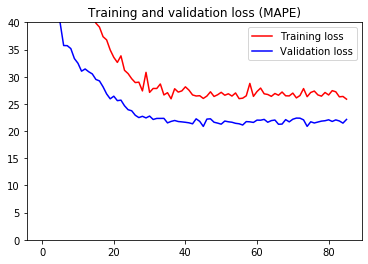

<Figure size 432x288 with 0 Axes>

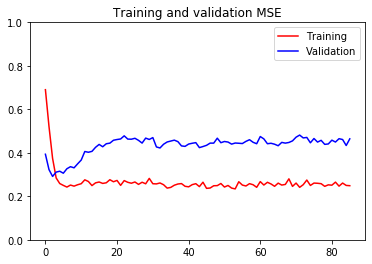

<Figure size 432x288 with 0 Axes>

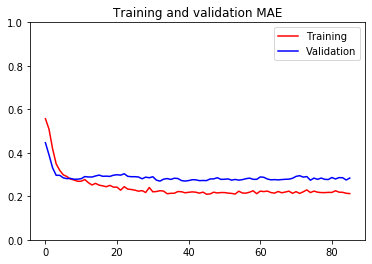

<Figure size 432x288 with 0 Axes>

In [20]:
#look at the metrics from QAT 
%matplotlib inline

loss = quant2_history.history['loss']
val_loss = quant2_history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.ylim(0,40)

plt.title('Training and validation loss (MAPE)')
plt.legend(loc=0)
plt.figure()
plt.show()

mse = quant2_history.history['mse']
val_mse = quant2_history.history['val_mse']

plt.plot(epochs, mse, 'r', label='Training')
plt.plot(epochs, val_mse, 'b', label='Validation')
plt.ylim(0,1)

plt.title('Training and validation MSE')
plt.legend(loc=0)
plt.figure()
plt.show()

mae = quant2_history.history['mae']
val_mae = quant2_history.history['val_mae']

plt.plot(epochs, mae, 'r', label='Training')
plt.plot(epochs, val_mae, 'b', label='Validation')
plt.ylim(0,1)

plt.title('Training and validation MAE')
plt.legend(loc=0)
plt.figure()
plt.show()

In [21]:
#evaluate full model on val set:
quant_aware_model.evaluate(validation_generator)

13/13 [==============================] - 1s 91ms/step - loss: 20.9802 - mae: 0.2737 - mse: 0.4466


[20.980188369750977, 0.2737191319465637, 0.4465925395488739]

Stats : [0.1719     0.18893333 0.20501429 0.21877    0.23513846 0.27561
 0.32499583 0.35163158 0.37725385 0.4138     0.46188333]
Predicted Stats: [[0.1322344  0.16576296 0.21711156 0.23555547 0.2231853  0.28777295
  0.35647032 0.43325055 0.4403211  0.46925098 0.5798238 ]]


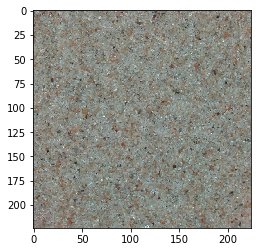

In [22]:
# use the validation generator as a sanity check

x = validation_generator.next()

how_many = 1
#how_many = batch_size

for i in range(0,how_many):
    image = x[0][i]   # batch[0] images, batch[1] labels... 
    #make a prediction
    img = np.expand_dims(image,axis=0)
    predStats = quant_aware_model.predict(img)
    
    plt.imshow(image.squeeze())   #squeeze for grayscale images  
    print('Stats :',x[1][i])
    print('Predicted Stats:', predStats)
    plt.show()

In [23]:
#TF lite converter for the QAT model

converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model2 = converter.convert()


tflite_models_dir = pathlib.Path("TFL_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)
tflite_model_file = tflite_models_dir/"SandCam_MNv2_QAT_notdense_aug22.tflite"
tflite_model_file.write_bytes(quantized_tflite_model2)

!ls -lh {tflite_models_dir}

INFO:tensorflow:Assets written to: /tmp/tmpw7rz0zpp/assets


INFO:tensorflow:Assets written to: /tmp/tmpw7rz0zpp/assets
/usr/lib/python3/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


total 21M
-rw-rw-r-- 1 ebgoldstein ebgoldstein 5.2M Aug 11 16:53 SandCam_MNv2_QAT_notdense_aug22_2stage.tflite
-rw-rw-r-- 1 ebgoldstein ebgoldstein 5.2M Aug 11 20:55 SandCam_MNv2_QAT_notdense_aug22.tflite
-rw-rw-r-- 1 ebgoldstein ebgoldstein  794 Aug 11 09:29 SandCam_MNv2_QAT_notdense_edgetpu.log
-rw-rw-r-- 1 ebgoldstein ebgoldstein 5.3M Aug 11 09:29 SandCam_MNv2_QAT_notdense_edgetpu.tflite
-rw-rw-r-- 1 ebgoldstein ebgoldstein 5.2M Aug 11 09:29 SandCam_MNv2_QAT_notdense.tflite


In [24]:
#Load QAT model into TFlite intepreter
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

Stats : [0.13601667 0.15683333 0.17785455 0.19442    0.21333571 0.25507931
 0.30286667 0.3283     0.3537     0.39028571 0.4422    ]
Predicted Stats: [[0.13973135 0.17340401 0.1952941  0.21060133 0.21451569 0.27774626
  0.3626276  0.4210945  0.49456805 0.5300032  0.6493169 ]]


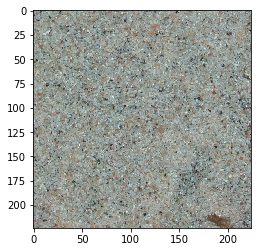

In [25]:
#Sanity check on image 

#SET THE IMAGE
Timage = validation_generator.next()
test_image = np.expand_dims(Timage[0][1],axis=0)

#dynamic range quant
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_index, test_image)
interpreter.invoke()
predictionsQAT = interpreter.get_tensor(output_index)

plt.imshow(Timage[0][1])

print('Stats :',Timage[1][1])
print('Predicted Stats:', predictionsQAT)

plt.grid(False)

In [26]:
testdf = df
test_data_dir = '../data/CropPics'
testdf = testdf.reset_index()  # make sure indexes pair with number of rows
testdf.head()

,index,CropName,D2mm,D5mm,D10mm,D16mm,D25mm,D50mm,D75mm,D84mm,D90mm,D95mm,D98mm,Skew,kurtosis
0,0,F1crop1.jpg,0.20230,0.254533,0.328300,0.416660,0.600230,1.048938,1.475019,1.689950,1.941339,2.242900,2.620533,-0.310142,0.991912
1,1,F1crop2.jpg,0.16795,0.194180,0.224125,0.255589,0.305320,0.481422,0.973960,1.420417,2.142912,2.982250,3.979850,0.298446,0.965102
2,2,F1crop3.jpg,0.12780,0.143893,0.160164,0.175800,0.198063,0.304044,0.539893,0.700033,0.897300,1.171850,1.598150,0.246834,0.857151
3,3,F1crop4.jpg,0.21795,0.272550,0.345870,0.428717,0.621250,1.283000,1.820650,2.039876,2.240500,2.532171,2.873250,-0.397723,0.849624
4,4,F1crop5.jpg,0.13435,0.153475,0.173900,0.193591,0.221419,0.332433,0.780375,1.138830,1.531636,1.851430,2.375586,0.384490,0.810154


In [27]:
#Load QAT model into TFlite intepreter
tflite_models_dir = pathlib.Path("TFL_models/")
tflite_model_file = tflite_models_dir/"SandCam_MNv2_QAT_notdense_aug22.tflite"
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

Stats : [0.16795 0.19418 0.224125 0.255588888888889 0.30532 0.48142222222222203
 0.97396 1.4204166666666698 2.1429125 2.98225]
Predicted Stats: [[0.12084099 0.14909332 0.17018554 0.17612435 0.18753847 0.24238847
  0.33603987 0.42163754 0.442871   0.48991826 0.6241557 ]]


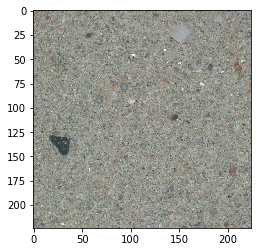

In [28]:
#Sanity check on a single image 
pix_dim = 224
imsize = (pix_dim, pix_dim) 

#SET THE IMAGE
imgp = "../data/CropPics/F7crop21.jpg"
img = tf.keras.preprocessing.image.load_img(imgp,target_size = imsize)
img = tf.keras.preprocessing.image.img_to_array(img)
img = img/255
test_image = np.expand_dims(img,axis=0)

#set up tensors and rpedict
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_index, test_image)
interpreter.invoke()
predictionsQAT = interpreter.get_tensor(output_index)

#show results
plt.imshow(img)

print('Stats :', testdf.iloc[1,2:12].values )
print('Predicted Stats:', predictionsQAT)

plt.grid(False)

In [29]:
#Evaluate on all images:
# 1. loop over all rows in data frame
# 2. grab image path
# 3. evaluate image w/ TFLite
# 4. write output to df
# 5. make plot

# fn to do tflite prediction
def TFLitePred (imgpath):
    pix_dim = 224
    imsize = (pix_dim, pix_dim) 
    #SET THE IMAGE
    img = tf.keras.preprocessing.image.load_img(imgpath,target_size = imsize)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255
    test_image = np.expand_dims(img,axis=0)

    #set up tensors and rpedict
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    interpreter.set_tensor(input_index, test_image)
    interpreter.invoke()
    predictionsQAT = interpreter.get_tensor(output_index)
    
    return predictionsQAT
    

In [30]:
#mmake an empty dictionary to hold predictions
pred_dict = []

## loop over all rows in data frame, grab image path, evaluate image w/ TFLite helper fn, 
# then flatten results adn append ot the dictionary
for index, row in testdf.iterrows():
    imgpath = "../data/CropPics/" + row['CropName']
    pred = TFLitePred (imgpath).flatten()
    pred_dict.append(pred)
    #print(pred)

#turn dicitonary into dataframe, add columns, and add to the test df
predictions = pd.DataFrame.from_dict(pred_dict)
predictions.columns=["pD2mm", "pD5mm", "pD10mm", "pD16mm",
"pD25mm","pD50mm", "pD75mm", "pD84mm", "pD90mm",
"pD95mm", "pD98mm"]
predictions.head()

testdf = testdf.join(predictions)

testdf.head()

,index,CropName,D2mm,D5mm,D10mm,D16mm,D25mm,D50mm,D75mm,D84mm,...,pD5mm,pD10mm,pD16mm,pD25mm,pD50mm,pD75mm,pD84mm,pD90mm,pD95mm,pD98mm
0,0,F1crop1.jpg,0.20230,0.254533,0.328300,0.416660,0.600230,1.048938,1.475019,1.689950,...,0.485682,0.550328,0.604222,0.625124,1.078947,1.716167,1.933473,2.266255,2.442850,2.941404
1,1,F1crop2.jpg,0.16795,0.194180,0.224125,0.255589,0.305320,0.481422,0.973960,1.420417,...,0.276402,0.192047,0.362778,0.312568,0.541060,1.058935,1.378008,1.625265,1.799519,2.177376
2,2,F1crop3.jpg,0.12780,0.143893,0.160164,0.175800,0.198063,0.304044,0.539893,0.700033,...,0.211200,0.228418,0.266893,0.234399,0.364601,0.420215,0.499964,0.590067,0.667842,0.761768
3,3,F1crop4.jpg,0.21795,0.272550,0.345870,0.428717,0.621250,1.283000,1.820650,2.039876,...,0.453737,0.486279,0.760897,0.635265,1.268479,1.722491,2.284800,2.155945,2.230432,3.028447
4,4,F1crop5.jpg,0.13435,0.153475,0.173900,0.193591,0.221419,0.332433,0.780375,1.138830,...,0.189759,0.234332,0.257763,0.251413,0.323500,0.441137,0.515389,0.609187,0.647763,0.782569


(0, 6)

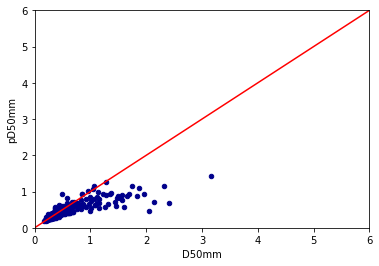

In [31]:
#make a single observed vs predicted plot

ax1 = testdf.plot.scatter(x='D50mm', y='pD50mm', c='DarkBlue')

line = mlines.Line2D([0, 6], [0, 6], color='red')
ax1.add_line(line)
ax1.set_xlim([0,6])
ax1.set_ylim([0,6])

In [32]:
#plot of mean absolute percent error for all range bins

error = pd.DataFrame(100*abs(testdf.iloc[:,2:13].values - predictions.values)/testdf.iloc[:,2:13].values)


error.columns = columns
error.head()

,D2mm,D5mm,D10mm,D16mm,D25mm,D50mm,D75mm,D84mm,D90mm,D95mm,D98mm
0,40.826359,90.812663,67.629703,45.015543,4.147446,2.860821,16.348794,14.410092,16.736685,8.914813,12.244493
1,27.404422,42.343001,14.312629,41.937935,2.373759,12.387826,8.724708,2.985632,24.156248,39.659014,45.289998
2,13.716533,46.776102,42.615565,51.816268,18.345700,19.917307,22.166946,28.580028,34.239683,43.009577,52.334414
3,32.006526,66.478496,40.595849,77.482399,2.255992,1.131820,5.391444,12.006805,3.773942,11.916231,5.401458
4,25.054183,23.641782,34.751046,33.148204,13.546166,2.687307,43.471131,54.743995,60.226378,65.012840,67.057856


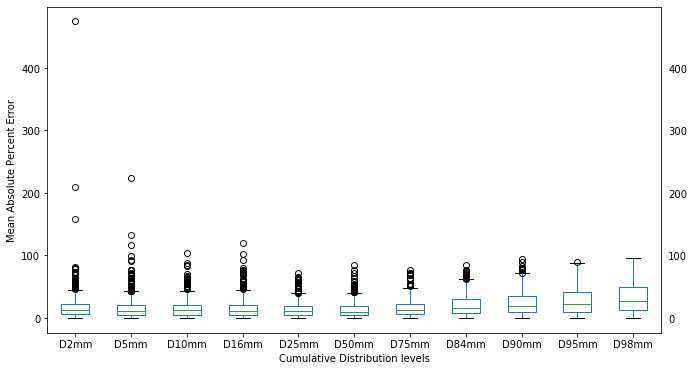

In [33]:
ax = error.plot.box(figsize = [11,6])
ax.set_ylabel('Mean Absolute Percent Error')
ax.set_xlabel('Cumulative Distribution levels')
ax. tick_params(labelright=True)

In [ ]:
#compile the tflite model for edge tpu via: 
#https://github.com/google-coral/tutorials/blob/master/compile_for_edgetpu.ipynb
#https://colab.research.google.com/github/google-coral/tutorials/blob/master/compile_for_edgetpu.ipynb